# Adult Dataset - Projet de Classification

**Objectif :** Prédire si le revenu annuel d'un individu est supérieur à 50 000 $  
**Source :** Barry Becker, base de données du recensement américain 1994  
**Dataset :** 48 842 individus · 14 features · 1 variable cible binaire  
**DOI :** [10.24432/C5XW20](https://doi.org/10.24432/C5XW20)

---
## Sommaire

In [1]:
from pathlib import Path
import os

# Constantes
SEED = 42
FIG_DIR = Path.cwd() / 'figures'

In [2]:
# graine pour la reproductibilité de l'aléatoire
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'

In [3]:
FIG_DIR.mkdir(parents=True, exist_ok=True)

## 1. Chargement des données

In [4]:
# librairies
from urllib import request
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pprint import pprint

# scpipy
from scipy.stats import spearmanr, chi2_contingency, kruskal

# scikit learn
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.dummy import DummyClassifier

# tensorflow/keras
import tensorflow as tf
import keras

In [5]:
# graines pour la reproductibilité de l'aléatoire
def set_seeds(seed: int = SEED) -> None:
    """
    Fixe toutes les sources d'aléatoire pour garantir la reproductibilité.
    (Python 3.12.10, NumPy 2.4, TensorFlow 2.20, Keras 3.13)

    Paramètres
    ----------
    seed : int
        Valeur de la seed (défaut : 42).

    Notes
    -----
    - Les variables d'environnement PYTHONHASHSEED, TF_DETERMINISTIC_OPS
      et TF_CUDNN_DETERMINISTIC doivent être définies AVANT l'import de
      TensorFlow pour être prises en compte.
    - Le déterminisme complet sur GPU n'est pas garanti pour toutes les
      opérations CUDA, même avec ces réglages.
    """
    # Python
    random.seed(seed)

    # Numpy
    np.random.seed(seed)
    # pour utiliser np.random.Generator.choice ou np.random.Generator.shuffle
    # exemple : set_seeds.rng.choice(...)
    set_seeds.rng = np.random.default_rng(seed)

    # Tensorflow
    tf.random.set_seed(seed)

    # Déterminisme des opérations (coût possible en performance sur GPU)
    try:
        tf.config.experimental.enable_op_determinism()
    except RuntimeError:
        # Lève une RuntimeError si déjà activé ou si le GPU ne le supporte pas
        pass

    # keras.utils.set_random_seed pose Python + NumPy + backend en un appel
    # Redondant avec les appels précédents, mais garantit la cohérence
    # si Keras utilise un backend autre que TF (JAX, PyTorch)
    keras.utils.set_random_seed(seed)

    # stockage de la seed (pour les random_state Scikit-Learn ou XGBoost)
    set_seeds.seed = seed

    return

set_seeds()
print(f"Graine paramétrée : {set_seeds.seed}")

Graine paramétrée : 42


In [6]:
np.random.choice(['1', '2'])

np.str_('1')

In [7]:
sns.set_theme('paper')

In [8]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
adult = fetch_ucirepo(id=2) 

In [9]:
# métadonnées 
pprint(adult.metadata) 

{'abstract': 'Predict whether annual income of an individual exceeds $50K/yr '
             'based on census data. Also known as "Census Income" dataset. ',
 'additional_info': {'citation': None,
                     'funded_by': None,
                     'instances_represent': None,
                     'preprocessing_description': None,
                     'purpose': None,
                     'recommended_data_splits': None,
                     'sensitive_data': None,
                     'summary': 'Extraction was done by Barry Becker from the '
                                '1994 Census database.  A set of reasonably '
                                'clean records was extracted using the '
                                'following conditions: ((AAGE>16) && (AGI>100) '
                                '&& (AFNLWGT>1)&& (HRSWK>0))\n'
                                '\n'
                                'Prediction task is to determine whether a '
                               

In [10]:
print(adult.metadata['additional_info']['variable_info']) 

Listing of attributes:

>50K, <=50K.

age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: Unite

In [11]:
# description des variable 
adult.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,NaN,NaN,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,NaN,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [12]:
# dataframe globale
df = adult.data.original
print(f'Dataset complet : {df.shape[0]:_} lignes × {df.shape[1]} colonnes')

Dataset complet : 48_842 lignes × 15 colonnes


In [13]:
# Noms des colonnes
cols = adult.data.headers.tolist()
target = ['income']
features = [col for col in cols if col not in target]

In [14]:
# aperçu des 5 premières lignes
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 2. Description et nettoyage des données

### 2.1 Types des variables

In [15]:
# nom et type des variables
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             48842 non-null  int64
 1   workclass       47879 non-null  str  
 2   fnlwgt          48842 non-null  int64
 3   education       48842 non-null  str  
 4   education-num   48842 non-null  int64
 5   marital-status  48842 non-null  str  
 6   occupation      47876 non-null  str  
 7   relationship    48842 non-null  str  
 8   race            48842 non-null  str  
 9   sex             48842 non-null  str  
 10  capital-gain    48842 non-null  int64
 11  capital-loss    48842 non-null  int64
 12  hours-per-week  48842 non-null  int64
 13  native-country  48568 non-null  str  
 14  income          48842 non-null  str  
dtypes: int64(6), str(9)
memory usage: 5.6 MB


In [16]:
# les colonnes de type entier sont les variables numériques
num_features = list(df.select_dtypes(include='number'))
num_features

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [17]:
df[num_features].head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [18]:
# les colonnes de type str doivent être des variables catégorielles
cat_features = list(df.select_dtypes(exclude='number'))
cat_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'income']

In [19]:
df[cat_features].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [20]:
# changement de type en catégories
df[cat_features] = df[cat_features].astype('category')

### 2.2 Description des variables

In [21]:
# description des variables numériques
df.describe() \
  .round() \
  .astype(int)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842,48842,48842,48842,48842,48842
mean,39,189664,10,1079,88,40
std,14,105604,3,7452,403,12
min,17,12285,1,0,0,1
25%,28,117550,9,0,0,40
50%,37,178144,10,0,0,40
75%,48,237642,12,0,0,45
max,90,1490400,16,99999,4356,99


Remarques : 
- à quoi sert la variable `fnlwgt` ? utile ?
- les valeurs > 0 des variables `capital-gain` et `capital-loss` représentent moins de 25 % du dataset
- la majorité des personnes travaillent entre 40 et 45 heures (autres == outliers ?)

In [22]:
print('Valeurs uniques des variables catégorielles :')
for cet_feature in cat_features:
    print(f'\t- {cet_feature} : {df[cet_feature].cat.categories.to_list()}')

Valeurs uniques des variables catégorielles :
	- workclass : ['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']
	- education : ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college']
	- marital-status : ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']
	- occupation : ['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']
	- relationship : ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife']
	- race : ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White']
	- sex : ['Female', 'Mal

Remarques : 
- attention, précence de `?` : valeurs volontairement manquantes ? (contrairement à NaN)
- la variable `education` est-elle redondante avec la variable `education-num` ? si c'est le cas autant garder `education-num` qui conserve une certaine notion d'ordre.
- `native-country` contient-il plus d'informations qu'une varaible qui regrouperait les pays par zones géographiques et culturelles ?
- les variables `workclass` et `occupation` sont-elles liées et redondantes ? si oui, laquelle apporterait le plus d'informations ?
- idem pour `marital-status` et `relationship`
- la variable cible devrait être nétoyée (`.` en trop) et encodée 0 pour <=50K et 1 pour >50K ?

In [23]:
df[target] = df[target].astype(str) \
                       .map(lambda x: x.replace('.', ''))

### 2.3 Gestion des valeurs manquantes

La présence de `?` dans certaines colonnes (en plus des NaN) suggère des valeurs volontairement manquantes. Ces informations ne devraient sans doute pas être traitées comme des NaN (oublis/erreurs) car pourrait contenir d'autres informations.

In [24]:
missing = df.isna().sum()
print('Valeurs manquantes (nan uniqument) :')
print(missing[missing > 0] / df.shape[0])

Valeurs manquantes (nan uniqument) :
workclass         0.019717
occupation        0.019778
native-country    0.005610
dtype: float64


In [25]:
missing = df.replace('?', np.nan).isna().sum()
print('Valeurs manquantes (nan ou ?) :')
print(missing[missing > 0])

Valeurs manquantes (nan ou ?) :
workclass         2799
occupation        2809
native-country     857
dtype: int64


In [26]:
col_missing = missing[missing > 0].index.to_list()
for v in col_missing:
    print(f'Distribution des revenus pour les valeurs manquantes de la variable `{v}` :')
    v_mode = df[v].mode()[0]
    print(f'Mode de la variable : {v_mode}')
    display(
        pd.DataFrame({
            'Missing (NaN)': df.loc[df[v].isna(), target].value_counts(normalize=True),
            'Unknown (?)': df.loc[df[v] == '?', target].value_counts(normalize=True),
            'Others' : df.loc[(df[v] != '?') & ~df[v].isna(), target].value_counts(normalize=True),
            'Mode' :   df.loc[df[v] == v_mode, target].value_counts(normalize=True),
        }).round(4)
    )
    print()

Distribution des revenus pour les valeurs manquantes de la variable `workclass` :
Mode de la variable : Private


,Missing (NaN),Unknown (?),Others,Mode
income,,,,
<=50K,0.9232,0.896,0.7519,0.7821
>50K,0.0768,0.104,0.2481,0.2179



Distribution des revenus pour les valeurs manquantes de la variable `occupation` :
Mode de la variable : Prof-specialty


,Missing (NaN),Unknown (?),Others,Mode
income,,,,
<=50K,0.9234,0.8964,0.7519,0.5489
>50K,0.0766,0.1036,0.2481,0.4511



Distribution des revenus pour les valeurs manquantes de la variable `native-country` :
Mode de la variable : United-States


,Missing (NaN),Unknown (?),Others,Mode
income,,,,
<=50K,0.7299,0.7496,0.761,0.756
>50K,0.2701,0.2504,0.239,0.244


Pour les variables `workclass` et `occupation`, nous n'avons pas des distributions similaires entre les `?`, les `nan` et les autres valeurs du DataSet ou de celle du mode. Créer une catégorie `Unknown` semble être le plus approprié dans ce cas car nous somme sur un manque MNAR (Missing Not At Random).

Concernant la variable `native-country`, les `?` et `nan` semble avoir des distributions similaires au reste du DataSet ou à celle du mode. Manque type MCAR (Missing Completely At Random). Nous avons donc 2 possibilités : supprimer ces valeurs ou les remplacer par le mode.

In [27]:
# corrections des variables `workclass` et `occupation`
df[['workclass', 'occupation']] = df[['workclass', 'occupation']].replace('?', np.nan) \
                                                                 .astype(str) \
                                                                 .fillna('Unknown') \
                                                                 .astype('category')

df[['workclass', 'occupation']].isna().sum()

workclass     0
occupation    0
dtype: int64

In [28]:
# valeurs manquantes restantes (variable 'native-country')
missing = df.replace('?', np.nan).isna().sum()
print('Valeurs manquantes (nan uniqument) :')
print(missing[missing > 0] / df.shape[0])

Valeurs manquantes (nan uniqument) :
native-country    0.017546
dtype: float64


Les valeurs manquantes sur `native-country` ne représentant que 2% du DataSet, pour un manque type MCAR, le plus simple est de supprimer les entrées correspondantes. En effet, il semblerait peu probable, le mode étant `United-States`, qu'un natif des USA ne renseigne pas son pays natif (`?`). Un oubli (`nan`) pourait être probable, mais dans le doute, il semble plus approprié de procéder ainsi.

In [29]:
df = df.replace('?', np.nan)
df.dropna(subset='native-country', inplace=True)
print(f'Velurs manquantes restantes : {df.isna().sum().sum()}')

Velurs manquantes restantes : 0


### 2.4 Nettoyage

Nous allons encoder la variable cible et stocker dans des dictionnaires les techniques d'encodage/décodage

In [30]:
# nettoyage de la variable cible
if np.all(df[target].dtypes == 'str'):
    # sauvegarde de la variable cible avant encodage
    df_target = df[target]

# dictionnaire d'encodage de la variable cible
encode_target = {t: {val: i  for i, val in enumerate(sorted(df[t].unique()))} for t in target}
print(encode_target)

{'income': {'<=50K': 0, '>50K': 1}}


In [31]:
# modification
df[target] = df_target.replace(encode_target) \
                      .astype(int)

In [32]:
# dictionnaire pour le décodage de la variable cible
decode_target = {key: {v: k for k, v in val.items()} for key, val in encode_target.items()}
decode_target

{'income': {0: '<=50K', 1: '>50K'}}

In [33]:
# test décodage
df.replace(decode_target).head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [34]:
# vérification encodage-décodage
np.all(df.replace(decode_target)[target] == df_target)

np.True_

Regardons maintenant la variable `fnlwgt`. Il n'y a pas d'information sur cette dernière dans les métadonnées. Toutefois, en téléchargeant les fichiers directement depuis le site sans utiliser `ucimlrepo`, nous pouvons lire ceci dans `adult.names` :

In [35]:
with open('data/adult.names', 'r') as f:
    adult_names = f.readlines()
print(''.join(adult_names[68:92]))

| Description of fnlwgt (final weight)
|
| The weights on the CPS files are controlled to independent estimates of the
| civilian noninstitutional population of the US.  These are prepared monthly
| for us by Population Division here at the Census Bureau.  We use 3 sets of
| controls.
|  These are:
|          1.  A single cell estimate of the population 16+ for each state.
|          2.  Controls for Hispanic Origin by age and sex.
|          3.  Controls by Race, age and sex.
|
| We use all three sets of controls in our weighting program and "rake" through
| them 6 times so that by the end we come back to all the controls we used.
|
| The term estimate refers to population totals derived from CPS by creating
| "weighted tallies" of any specified socio-economic characteristics of the
| population.
|
| People with similar demographic characteristics should have
| similar weights.  There is one important caveat to remember
| about this statement.  That is that since the CPS sample is
| a

`fnlwgt` est donc un outil statistique qui permet de s'assurer que les données recueillies auprès de quelques milliers de personnes représentent fidèlement la population américaine. L'utiliser en tant que variable pour l'entraînement n'apporterait rien. Nous pourrions l'utiliser en tant que `sample_weight` pour l'entraînement de nos modèles, mais il est probable que cela creuserait le déséquilibre entre nos classes.

In [36]:
# distribution normalisée des valeurs de la variables pour les deux classes cibles
(df.replace(decode_target).groupby(target[0])['fnlwgt']).describe().T.round(4) / df.fnlwgt.max()

income,<=50K,>50K
count,0.024502,0.007694
mean,0.127477,0.126360
std,0.071628,0.068790
min,0.008243,0.009238
25%,0.078458,0.079684
50%,0.119942,0.118570
75%,0.160396,0.156624
max,1.000000,0.822989


La distribution des valeurs semble homogène entre les deux classes pour les premiers quartiles, mais la classe majoritaire (`<=50K`) semble regrouper les valeurs les plus élévées sur le dernier quartile, ce qui creuserait le déséquilibre entre les classes si utilisé en tant que `sample_weight`.

In [37]:
def remove_col(col, df=df):
    """Permet de supprimer proprement en place une colonne si elle existe dans un DataFrame"""
    if col in df.columns:
        df.drop(columns=col, inplace=True)
        print(f"Colonne '{col}' supprimée.")
    else:
        print(f"Pas de colonne '{col}' dans le DataFrame.")

remove_col('fnlwgt')

Colonne 'fnlwgt' supprimée.


Passons aux variables `education` et `education-num`. Ces deux variables semble redondantes :

In [38]:
df[['education', 'education-num']].groupby('education')['education-num'].unique()

education
10th             [6]
11th             [7]
12th             [8]
1st-4th          [2]
5th-6th          [3]
7th-8th          [4]
9th              [5]
Assoc-acdm      [12]
Assoc-voc       [11]
Bachelors       [13]
Doctorate       [16]
HS-grad          [9]
Masters         [14]
Preschool        [1]
Prof-school     [15]
Some-college    [10]
Name: education-num, dtype: object

Nous pouvons en effet observer une seule valeur de `education-num` pour chaque valeur d'`education`.

In [39]:
dict_education = df[['education-num', 'education']].drop_duplicates() \
                                                   .set_index('education-num', drop=True) \
                                                   .sort_index() \
                                                   .rename(columns={'education': 'education-num'}) \
                                                   .to_dict()
dict_education

{'education-num': {1: 'Preschool',
  2: '1st-4th',
  3: '5th-6th',
  4: '7th-8th',
  5: '9th',
  6: '10th',
  7: '11th',
  8: '12th',
  9: 'HS-grad',
  10: 'Some-college',
  11: 'Assoc-voc',
  12: 'Assoc-acdm',
  13: 'Bachelors',
  14: 'Masters',
  15: 'Prof-school',
  16: 'Doctorate'}}

Vérification du dictionnaire de décodage obtenu et suppression de la colonne `education` redondante. En effet, autant garder la colonne `education-num` qui conserve une notion d'ordinalité dans les données.

In [40]:
# vérification et suppression
if ('education' in df.columns) and np.all(df[['education-num']].replace(dict_education).values == df[['education']].values):
    remove_col('education')

Colonne 'education' supprimée.


Nous pouvons également nous poser la question de la redondance entre les variables `workclass` et `occupation`, ainsi qu'entre `marital-status` et `relationship`.

In [41]:
df[['workclass', 'occupation']].groupby('workclass')['occupation'].unique()

workclass
Federal-gov         ['Farming-fishing', 'Adm-clerical', 'Prof-spec...
Local-gov           ['Tech-support', 'Protective-serv', 'Farming-f...
Never-worked        ['Unknown']
Categories (15, str): ['Adm-cleric...
Private             ['Handlers-cleaners', 'Prof-specialty', 'Exec-...
Self-emp-inc        ['Exec-managerial', 'Craft-repair', 'Sales', '...
Self-emp-not-inc    ['Exec-managerial', 'Farming-fishing', 'Prof-s...
State-gov           ['Adm-clerical', 'Prof-specialty', 'Other-serv...
Unknown             ['Unknown']
Categories (15, str): ['Adm-cleric...
Without-pay         ['Farming-fishing', 'Craft-repair', 'Handlers-...
Name: occupation, dtype: object

In [42]:
df[['marital-status', 'relationship']].drop_duplicates()

,marital-status,relationship
0,Never-married,Not-in-family
1,Married-civ-spouse,Husband
2,Divorced,Not-in-family
4,Married-civ-spouse,Wife
6,Married-spouse-absent,Not-in-family
12,Never-married,Own-child
17,Never-married,Unmarried
19,Divorced,Unmarried
21,Separated,Unmarried
32,Divorced,Own-child


Nous verrons en dataviz ce qu'il convient de faire pour ces variables.

Une dernière variable à traiter est `native-country`, qui comporte énormément de valeurs. Ces dernières n'apportent peut-être pas autant d'information qu'un regroupement par zones géographiques et culturelles plus larges et pourraient même augmenter le risque de surapprentissage.

In [43]:
print(f"'native-country' comporte {df['native-country'].nunique()} valeurs uniques.")

'native-country' comporte 41 valeurs uniques.


In [44]:
df['native-country'].value_counts(normalize=True) \
                    .sort_values(ascending=False) \
                    .head(10)

native-country
United-States    0.913452
Mexico           0.019819
Philippines      0.006148
Germany          0.004293
Puerto-Rico      0.003835
Canada           0.003793
El-Salvador      0.003230
India            0.003147
Cuba             0.002876
England          0.002647
Name: proportion, dtype: float64

In [45]:
df['native-country'].value_counts() \
                    .sort_values(ascending=True) \
                    .head(10)

native-country
?                              0
Holand-Netherlands             1
Hungary                       19
Honduras                      20
Scotland                      21
Outlying-US(Guam-USVI-etc)    23
Yugoslavia                    23
Laos                          23
Trinadad&Tobago               27
Cambodia                      28
Name: count, dtype: int64

Comme on pouvait s'y attendre, plus de 90 % des personnes recensées sont nées aux US. Il est peu probable, eu égard à cette distribution, que la quantité d'information contenue dans cette variable, permettant discriminer la variable cible, soit faible. Le jeu de données est tellement dominé par les USA que les 40 autres pays deviennent du bruit statistique.

Nous allons utiliser le jeu de donnée M49 des nations unies pour faire correspondre `native-country` avec les régions et sous régions correspondantes.

In [46]:
# un  dataset est disponible sur ce repo : https://github.com/omnika-datastore/unsd-m49-standard-area-codes
URL = "https://raw.githubusercontent.com/omnika-datastore/unsd-m49-standard-area-codes/refs/heads/main/2022-09-24__CSV_UNSD_M49.csv"
df_unm49 = pd.read_csv(URL, sep=';')
df_unm49.head()

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
0,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Algeria,12,DZ,DZA,NaN,NaN,NaN
1,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Egypt,818,EG,EGY,NaN,NaN,NaN
2,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Libya,434,LY,LBY,NaN,NaN,NaN
3,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Morocco,504,MA,MAR,NaN,NaN,NaN
4,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Sudan,729,SD,SDN,x,NaN,NaN


In [47]:
# dictionnaires des régions et sous-régions :
dict_region = {'native-country': df_unm49[['Country or Area', 'Region Name']].set_index('Country or Area')['Region Name'].to_dict()}
dict_subregion = {'native-country': df_unm49[['Country or Area', 'Sub-region Name']].set_index('Country or Area')['Sub-region Name'].to_dict()}

In [48]:
# ajout des colonnes correspondantes dans le DataFrame
df['native-region'] = df[['native-country']].astype(str).replace(dict_region).astype('category')
df['native-subregion'] = df[['native-country']].astype(str).replace(dict_subregion).astype('category')

In [49]:
df['native-region'].unique()

['United-States', 'Americas', 'Asia', 'South', 'Puerto-Rico', ..., 'Scotland', 'Trinadad&Tobago', 'Vietnam', 'Hong', 'Holand-Netherlands']
Length: 20
Categories (20, str): ['Americas', 'Asia', 'Columbia', 'Dominican-Republic', ..., 'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia']

Petit problème, certains pays ne sont pas orthographiés de la même manière dans le dataset et dans M49.

In [50]:
df['native-region'].unique()[~df['native-region'].unique().isin(df_unm49['Region Name'])]

['United-States', 'South', 'Puerto-Rico', 'England', 'Iran', ..., 'Scotland', 'Trinadad&Tobago', 'Vietnam', 'Hong', 'Holand-Netherlands']
Length: 17
Categories (20, str): ['Americas', 'Asia', 'Columbia', 'Dominican-Republic', ..., 'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia']

In [51]:
trad_country = {'native-country': {
    'United-States': 'United States of America',
    'South': 'South Georgia and the South Sandwich Islands',
    'Puerto-Rico': 'Puerto Rico',
    'England': 'United Kingdom of Great Britain and Northern Ireland',
    'Iran': 'Iran (Islamic Republic of)',
    'Columbia': 'Colombia',
    'Laos': 'Lao People\'s Democratic Republic',
    'Taiwan': 'China', # pas référencé dans le M49
    'Dominican-Republic': 'Dominican Republic',
    'El-Salvador': 'El Salvador',
    'Yugoslavia': 'Serbia',  # n'existe plus aujourd'hui
    'Outlying-US(Guam-USVI-etc)': 'United States Minor Outlying Islands',
    'Scotland': 'United Kingdom of Great Britain and Northern Ireland',
    'Trinadad&Tobago': 'Trinidad and Tobago',
    'Vietnam': 'Viet Nam',
    'Hong': 'China, Hong Kong Special Administrative Region',
    'Holand-Netherlands': 'Netherlands'
}}

In [52]:
# correction des colonnes
df['native-region'] = df[['native-country']].astype(str).replace(trad_country).replace(dict_region).astype('category')
df['native-subregion'] = df[['native-country']].astype(str).replace(trad_country).replace(dict_subregion).astype('category')

In [53]:
df['native-region'].cat.categories

Index(['Americas', 'Asia', 'Europe', 'Oceania'], dtype='str')

In [54]:
df['native-subregion'].cat.categories

Index(['Eastern Asia', 'Eastern Europe', 'Latin America and the Caribbean',
       'Micronesia', 'Northern America', 'Northern Europe',
       'South-eastern Asia', 'Southern Asia', 'Southern Europe',
       'Western Europe'],
      dtype='str')

Nous avons donc maintenant le choix entre 4 grandes régions ou 10 sous-régions. Il est également possible de transformer cette variable `native-us` pour uniquement savoir si une personne est native des USA ou non.

In [55]:
df['native-us'] = (df['native-country'] == 'United-States').astype('category')

In [56]:
df.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,native-region,native-subregion,native-us
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,Americas,Northern America,True
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,Americas,Northern America,True
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,Americas,Northern America,True
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,Americas,Northern America,True
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,Americas,Latin America and the Caribbean,False


Pour mesurer rapidement laquelle de ces variable discrimine le mieux notre variable cible, nous allons calculer l'information mutuelle (MI) entre `income` et chacune des variables. Contrairement à la corrélation de Pearson, elle fonctionne très bien avec les catégories.

Plus le score est élevé, plus la variable a de pouvoir prédictif sur le salaire :

In [57]:
geo_vars = [col for col in df.columns if 'native-' in col]
geo_vars

['native-country', 'native-region', 'native-subregion', 'native-us']

In [58]:
for col in geo_vars:
    le = LabelEncoder()
    temp_encoded = le.fit_transform(df[col])
    mi_score = mutual_info_classif(temp_encoded.reshape(-1, 1), df[target[0]], discrete_features=[0])
    print(f"Mutual Information pour {col} : {mi_score[0]:.4f}")

Mutual Information pour native-country : 0.0058
Mutual Information pour native-region : 0.0004
Mutual Information pour native-subregion : 0.0044
Mutual Information pour native-us : 0.0008


`native-country` serait la plus discriminante. Toutefois, `native-subregion` est très proche. Elle conserve environ 75 % de l'information du pays. `native-us` et `native-region` sont très faibles, lles ont "écrasé" trop d'informations utiles.


Mieux vaut sand doute utiliser `native-subregion` qui a un meilleur ratio information/complexité : on perd un peu d'information par rapport au pays (0.0044 vs 0.0058), mais on réduit drastiquement le nombre de catégories. 


Un modèle (surtout un arbre de décision ou une régression logistique) sera beaucoup plus stable avec 10-12 sous-régions qu'avec 41 pays. D'autant que certains pays n'ont qu'un seul représentant (ex: Holand-Netherlands). Si par chance cette unique personne gagne $>50K$, le modèle va créer une règle absurde : "Si pays = Holand-Netherlands, alors salaire $>50K$". La sous-région règle ce problème en regroupant ces cas isolés.

Toutefois, il faut noter que tous ces scores sont faibles (proches de 0). À titre de comparaison, si on calcule la MI pour les variables `age`, `education-num` ou `occupation` :

In [59]:
for col, discrete in [('age', False), ('education-num', [0]), ('occupation', [0])]:
    le = LabelEncoder()
    temp_encoded = le.fit_transform(df[col])
    mi_score = mutual_info_classif(temp_encoded.reshape(-1, 1), df[target[0]], discrete_features=discrete)
    print(f"Mutual Information pour {col} : {mi_score[0]:.4f}")

Mutual Information pour age : 0.0685
Mutual Information pour education-num : 0.0641
Mutual Information pour occupation : 0.0638


On obtien des MI 10 fois plus élevés : la provenance géographique est une variable faible dans ce dataset. Cette feature aura sans doute peu d'importance pour nos modèles.

On peut également 

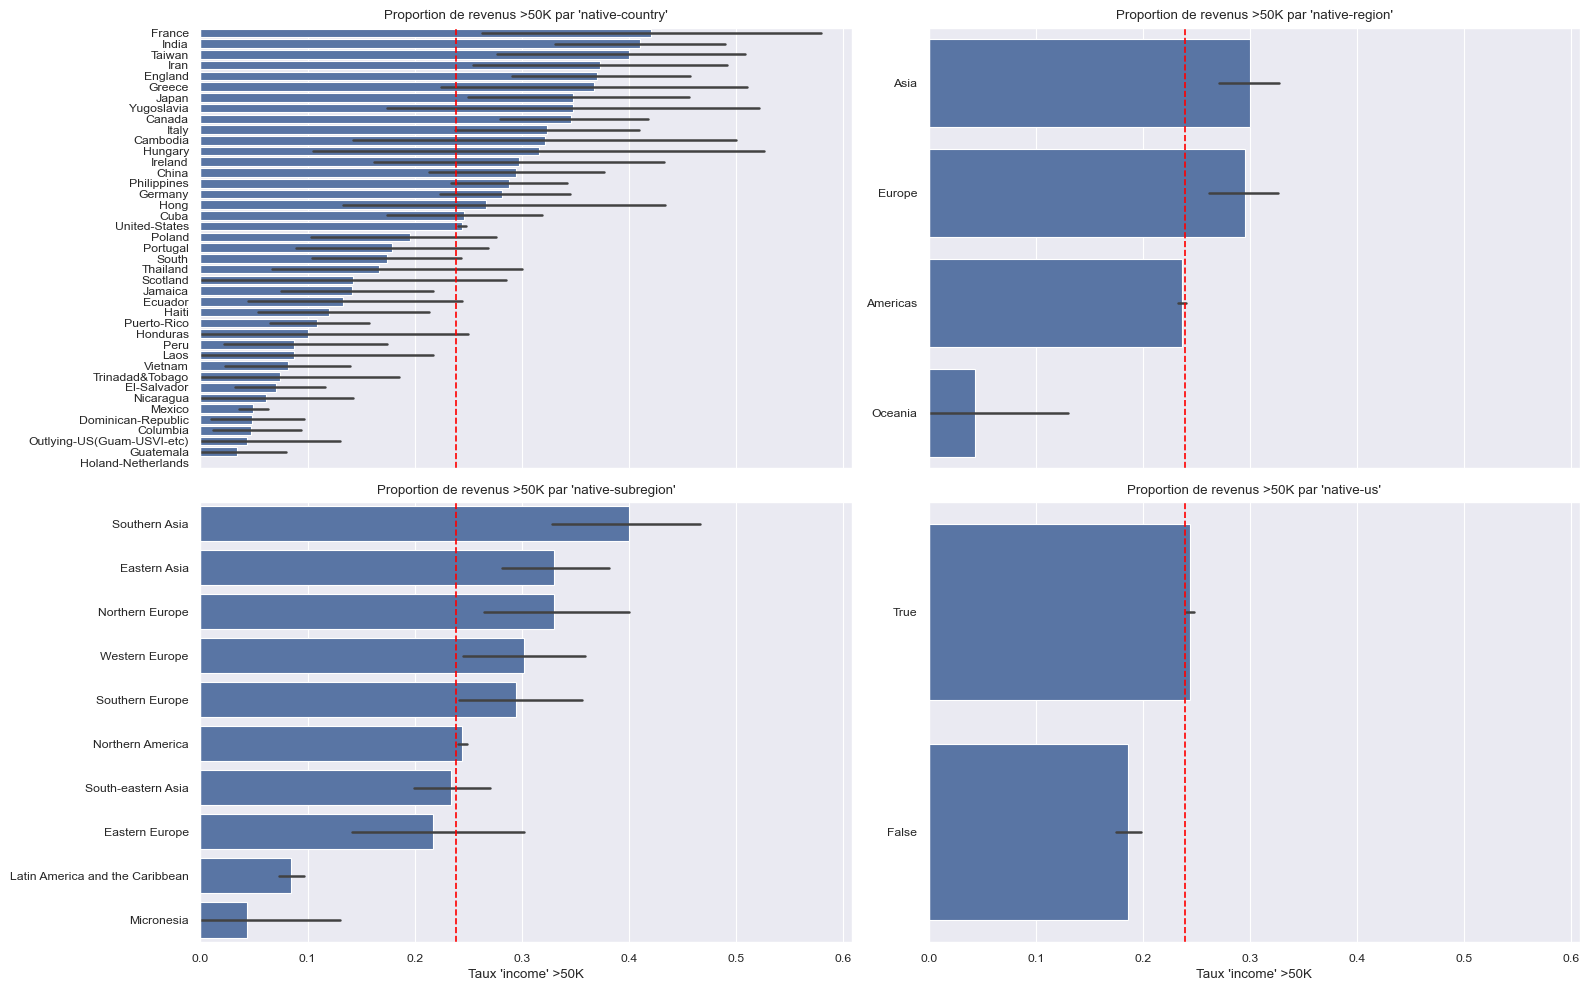

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

for ax, var in zip(axs.flatten(), geo_vars):
    df_temp = df.groupby(var)[target[0]].mean().sort_values(ascending=False)

    sns.barplot(data=df, x=target[0], y=var, order=df_temp.index, ax=ax)
    ax.axvline(df[target[0]].mean(), color='red', linestyle='--', label='moyenne globale')
    ax.set_title(f"Proportion de revenus >50K par '{var}'")
    ax.set_xlabel(f"Taux '{target[0]}' >50K")
    ax.set_ylabel('')

plt.tight_layout()
plt.savefig(FIG_DIR / '2-4_geo_discrimination.png', bbox_inches='tight')
plt.show()

On peut ainsi mieux comprendre pourquoi les variables `native-us` (0.0008) et `native-region` (0.0004) sont très faibles : elles cachent le fait que certains petits groupes d'immigrants (ex: France, Inde, Taiwan, Iran) ont statistiquement des taux de hauts revenus très élevés dans ce dataset, bien plus que la moyenne américaine. En les noyant dans des énormes régions ou dans un groupe "Non-USA", on perd ce signal.


On peut également voir, pour le découpage par pays, que les barres d'erreur sont immenses. En réalité, on as peu d'individus pour la plupart des pays, les taux de revenus $>50K$ sont donc très variables et ce n'est pas fiable, il y a beaucoup d'information "bruitée".

L'utilisation de `native-subregion` permet de réduire ce problème tout en conservant les taux de hauts revenus pour certains groupes de migrants avec les pays de l'Asie de l'Est, du Sud et d'Europe. Les barres d'erreur sont beaucoup plus courtes que pour les pays individuels. Les estimations sont donc plus robustes.

In [61]:
for col in geo_vars:
    if (col != 'native-subregion'):
        remove_col(col)

Colonne 'native-country' supprimée.
Colonne 'native-region' supprimée.
Colonne 'native-us' supprimée.


Voici le jeu de données nettoyé :

In [62]:
df.info()

<class 'pandas.DataFrame'>
Index: 47985 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               47985 non-null  int64   
 1   workclass         47985 non-null  category
 2   education-num     47985 non-null  int64   
 3   marital-status    47985 non-null  category
 4   occupation        47985 non-null  category
 5   relationship      47985 non-null  category
 6   race              47985 non-null  category
 7   sex               47985 non-null  category
 8   capital-gain      47985 non-null  int64   
 9   capital-loss      47985 non-null  int64   
 10  hours-per-week    47985 non-null  int64   
 11  income            47985 non-null  int64   
 12  native-subregion  47985 non-null  category
dtypes: category(7), int64(6)
memory usage: 2.9 MB


In [63]:
df.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income,native-subregion
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,0,Northern America
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0,Northern America
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0,Northern America
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0,Northern America
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,0,Latin America and the Caribbean


## 3. Analyse exploratoire

In [64]:
# Mise à jour des colonnes des features (on exclut la variable cible)
num_features = [col for col in df.select_dtypes(include='number') if col not in target]
cat_features = [col for col in df.select_dtypes(exclude='number') if col not in target]
print('Numériques :', num_features)
print('Catégorielles :', cat_features)

Numériques : ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Catégorielles : ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-subregion']


### 3.1 Distribution de la variable cible

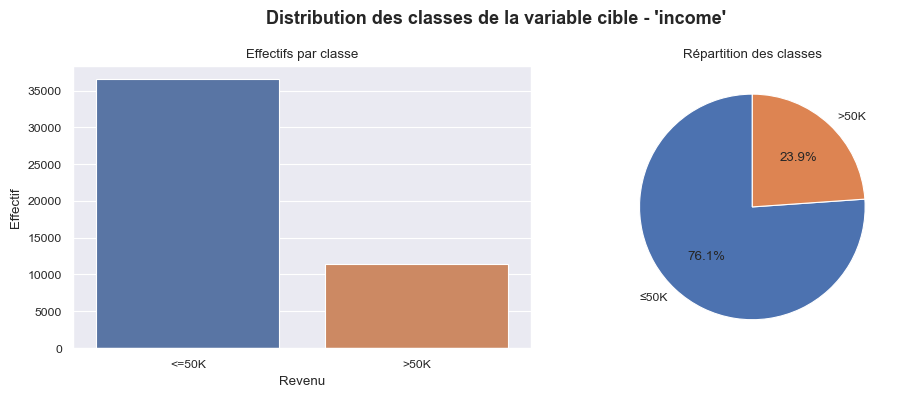

Ratio déséquilibre  ≤50K / >50K : 3.18
Classe majoritaire (≤50K) : 76.1%


In [65]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

plt.suptitle(f"Distribution des classes de la variable cible - '{target[0]}'", fontsize=13, fontweight='bold')

# Countplot
sns.countplot(x=target[0], data=df.replace(decode_target), ax=axs[0], hue=target[0], legend=False)
axs[0].set_title("Effectifs par classe")
axs[0].set_xlabel("Revenu")
axs[0].set_ylabel("Effectif")


# Camembert
counts = df[target[0]].value_counts().sort_index()
labels = ['≤50K', '>50K']

axs[1].pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Répartition des classes')

plt.tight_layout()
plt.savefig(FIG_DIR / '3-1_class_balance.png', bbox_inches='tight')
plt.show()

print(f"Ratio déséquilibre  ≤50K / >50K : {counts[0] / counts[1]:.2f}")
print(f"Classe majoritaire (≤50K) : {counts[0] / len(df) * 100:.1f}%")

Le graphique montre un déséquilibre de classes marqué : 76,1 % gagnent $\le50K$ contre seulement 23,9 % pour les $>50K$. Un modèle dummy qui prédirait toujours $\le50K$ aurait donc 76 % de succès.

### 3.2 Analyse univariée - Variables numériques

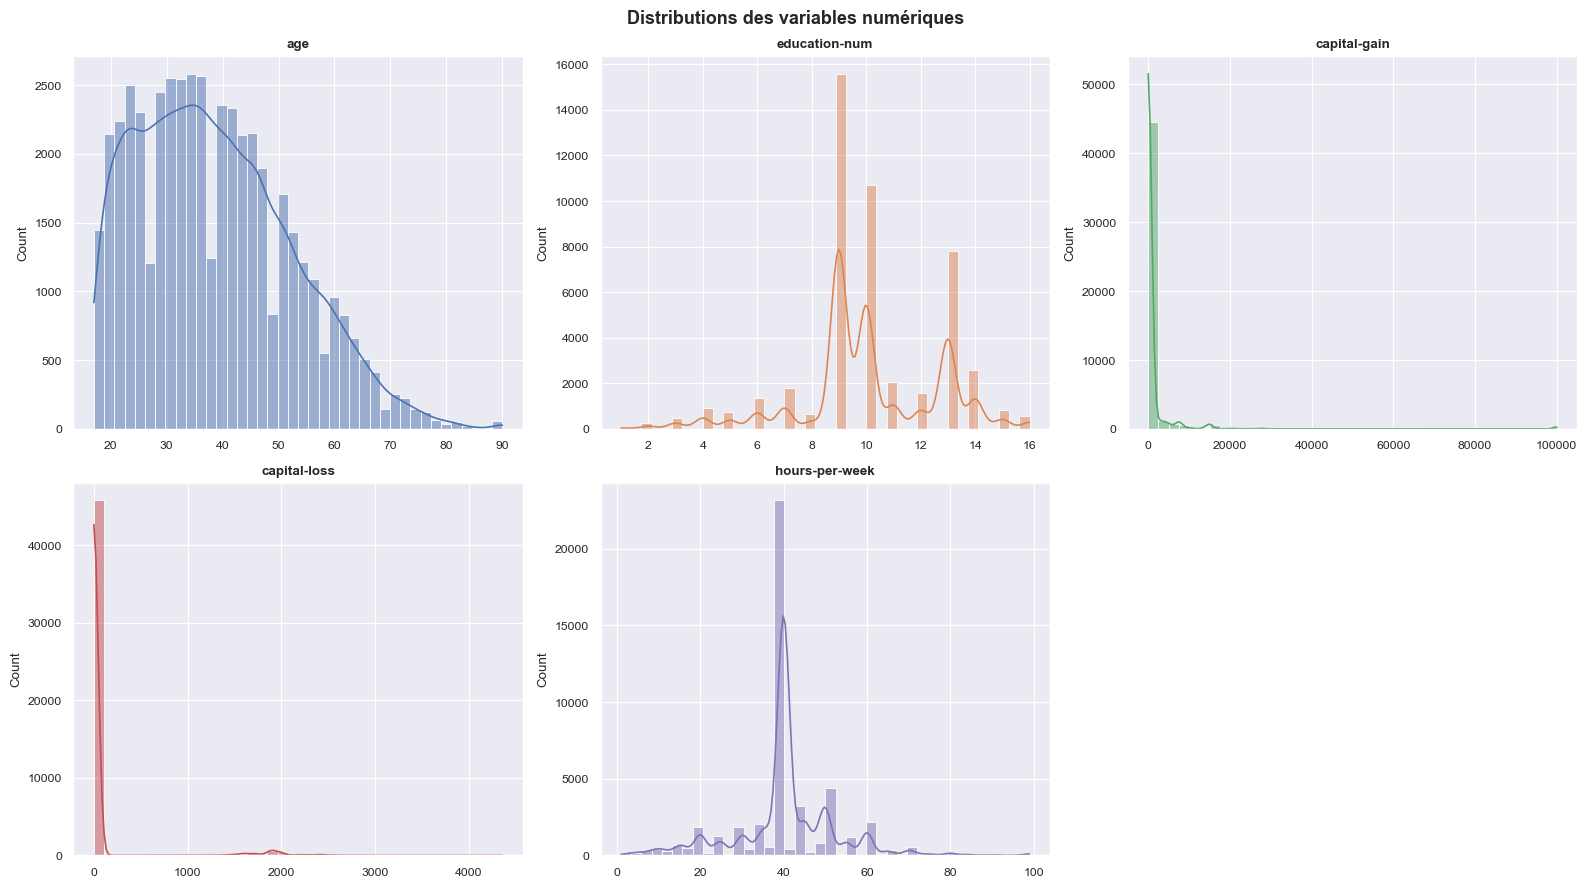

In [66]:
# Histogrammes + KDE
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
axs = axs.flatten()
palette = sns.color_palette(None, len(num_features))

for i, col in enumerate(num_features):
    sns.histplot(df[col], kde=True, ax=axs[i], color=palette[i], bins=40)
    axs[i].set_title(col, fontweight='bold')
    axs[i].set_xlabel('')
else:
    # les autres axes doivent être invisibilisés
    for ax in axs[i+1:]:
        ax.set_visible(False)

plt.suptitle('Distributions des variables numériques', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / '3-2_distrib_num.png', bbox_inches='tight')
plt.show()

1. `age` : la distribution est étalée à droite (skewed to the right). La majorité de la population se situe entre 25 et 45 ans Le nombre d'individus diminue progressivement à mesure que l'âge augmente, avec peu de personnes représentées au-delà de 70 ans.

2. `education-num` : distribution multimodale (plusieurs pics distincts) on est en réalité sur une variable catégorielle. Les pics les plus importants se situent à 9, 10 et 13. Ce qui correspond à la fin du Lycée et au début des études sup(9 pour le lycée (`HS-grad`), 10 pour ceux qui ont commencé des études sup `Some-college`, 13 pour BAC+3 `Bachelors`).

3. `capital-gain` & `capital-loss` : distributions extrêmement déséquilibrées (fortement asymétriques). La grande majorité des valeurs sont à 0. Pour `capital-gain`, on note une petite concentration de valeurs très élevées (autour de 100 000), ce qui suggère des "outliers" ou un plafond de déclaration. Ces variables risquent de poser problème pour certains modèles car peu diversifiées. Une transformation logarithmique ou un traitement des valeurs aberrantes pourrait être nécessaire.

4. `hours-per-week` : pic massif à 40 heures. La distribution est très centrée sur la semaine de travail standard de 40 heures, la "norme" du travail à plein temps domine largement le dataset. On voit toutefois des pics secondaires à 45, 50 et 60 heures, ainsi que des emplois à temps partiel (autour de 20h). 

Ces graphiques montrent que tes données ne suivent pas toutes une loi normale. Il faudra normaliser ces variables et potentiellement gérer les outliers (valeurs aberrantes).

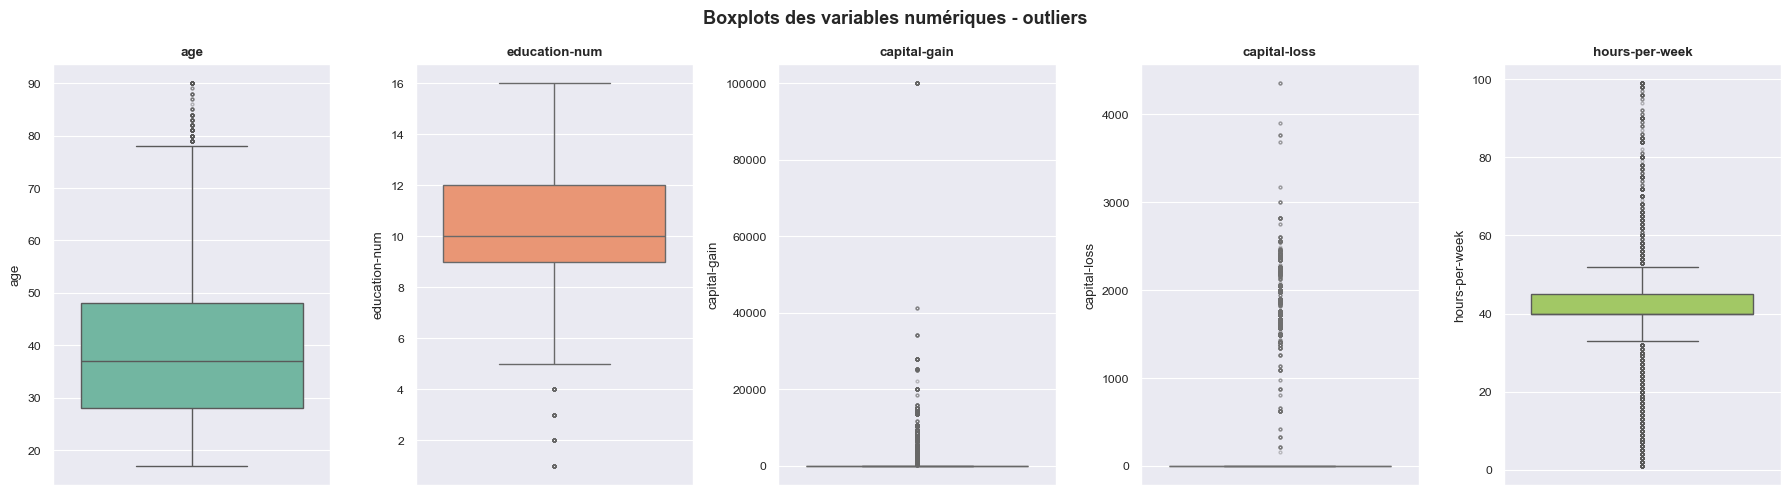

In [67]:
# Boxplots - détection des outliers
fig, axs = plt.subplots(1, 5, figsize=(18, 5))
palette = sns.color_palette('Set2', len(num_features))

for i, col in enumerate(num_features):
    sns.boxplot(y=df[col], ax=axs[i], color=palette[i],
                flierprops=dict(marker='o', markersize=2, alpha=0.4))
    axs[i].set_title(col, fontweight='bold')
    axs[i].set_xlabel('')

plt.suptitle('Boxplots des variables numériques - outliers', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / '3-2_boxplots_num.png', bbox_inches='tight')
plt.show()

1. `age` : On voit une série d'outliers uniquement sur la borne supérieure (entre 80 et 90 ans). Ce n'est pas anormal, ce sont des profils seniors. La médiane se situe proprement autour de 37 ans.

2. `education-num` : les outliers sont vers le bas (niveaux d'études très faibles, entre 1 et 4). La majorité des individus a un niveau d'études concentré entre 9 (Lycée) et 13 (Bac+3). Les personnes ayant très peu de scolarisation sont statistiquement rares dans ce jeu de données, d'où leur statut d'outliers.

3. `capital-gain` & `capital-loss` : la grande majorité des gens ont 0 gain/perte, la boîte est donc totalement écrasée sur la ligne du zéro. Chaque valeur positive est donc considérée comme un outlier par l'algorithme du boxplot. On remarque aussi un point isolé tout en haut du capital-gain (à 100 000). C'est un outlier extrême qui pourrait grandement influencer la moyenne.

4. `hours-per-week` : On a ici beaucoup de bruit avec des outliers en haut et en bas. Comme la norme est extrêmement forte à 40h, travailler 20h ou 60h suffit à être considéré comme un outlier. *NB. Les valeurs atteignant 100h/semaine sont physiquement possibles mais très suspectes ou représentatives de cas extrêmes.*

Les outliers pour ces variables, au sens de l'écart inter-quartile, ne semblent pas ici être des erreurs de saisies mais reflètent des situtations réelles particulières. Elles sont donc potentiellement vectrices d'information et il ne faudrait donc pas les supprimer.

In [68]:
# Statistiques descriptives + asymétrie + aplatissement
stats_df = pd.DataFrame({
    'moyenne':  df[num_features].mean().round(2),
    'médiane':  df[num_features].median().round(2),
    'std':      df[num_features].std().round(2),
    'skewness': df[num_features].skew().round(3),
    'kurtosis': df[num_features].kurtosis().round(3),
})
display(stats_df.style.background_gradient(subset=['skewness', 'kurtosis'], cmap='RdYlGn_r'))


,moyenne,médiane,std,skewness,kurtosis
age,38.640000,37.000000,13.730000,0.556000,-0.191000
education-num,10.070000,10.000000,2.560000,-0.313000,0.639000
capital-gain,1067.030000,0.000000,7373.260000,11.997000,155.672000
capital-loss,87.370000,0.000000,402.680000,4.573000,20.045000
hours-per-week,40.410000,40.000000,12.390000,0.238000,2.951000


1. `age` : la moyenne (38,64) est légèrement supérieure à la médiane (37,00), ce qui est confirmé par un skewness positif de 0,556 (étalement vers la droite). C'est une distribution relativement saine, bien que légèrement asymétrique.

2. `education-num` : la moyenne et la médiane sont presque identiques (~10), indiquant une distribution équilibrée autour de ce point. Le kurtosis (0,639) montre que les données sont légèrement plus concentrées autour de la moyenne qu'une loi normale. Les "outliers" sont simplement des individus ayant peu de scolarisation, ce qui est statistiquement rare mais tout à fait cohérent.

3. `capital-gain` & `capital-loss` : pour `capital-gain`, le skewness est extrême (11,99) et le kurtosis atteint 155,67. Cela signifie que la distribution a une queue extrêmement longue et "lourde". La médiane à 0,00 contre une moyenne de 1067 illustre l'impact massif des quelques personnes ayant de gros revenus financiers. On retrouve, dans une moindre mesure, les mêmes observations pour `capital-loss`. Ces variables nécessiteront probablement un traitement spécial pour ne pas fausser les modèles.

4. `hours-per-week` : La médiane à 40h est la norme absolue. Le kurtosis de 2,95 indique un pic de concentration très fort autour de cette valeur (la semaine de travail standard). Bien que mathématiquement considérés comme des outliers, travailler 20h ou 60h par semaine reste une réalité sociale courante.

### 3.3 Analyse univariée - Variables catégorielles

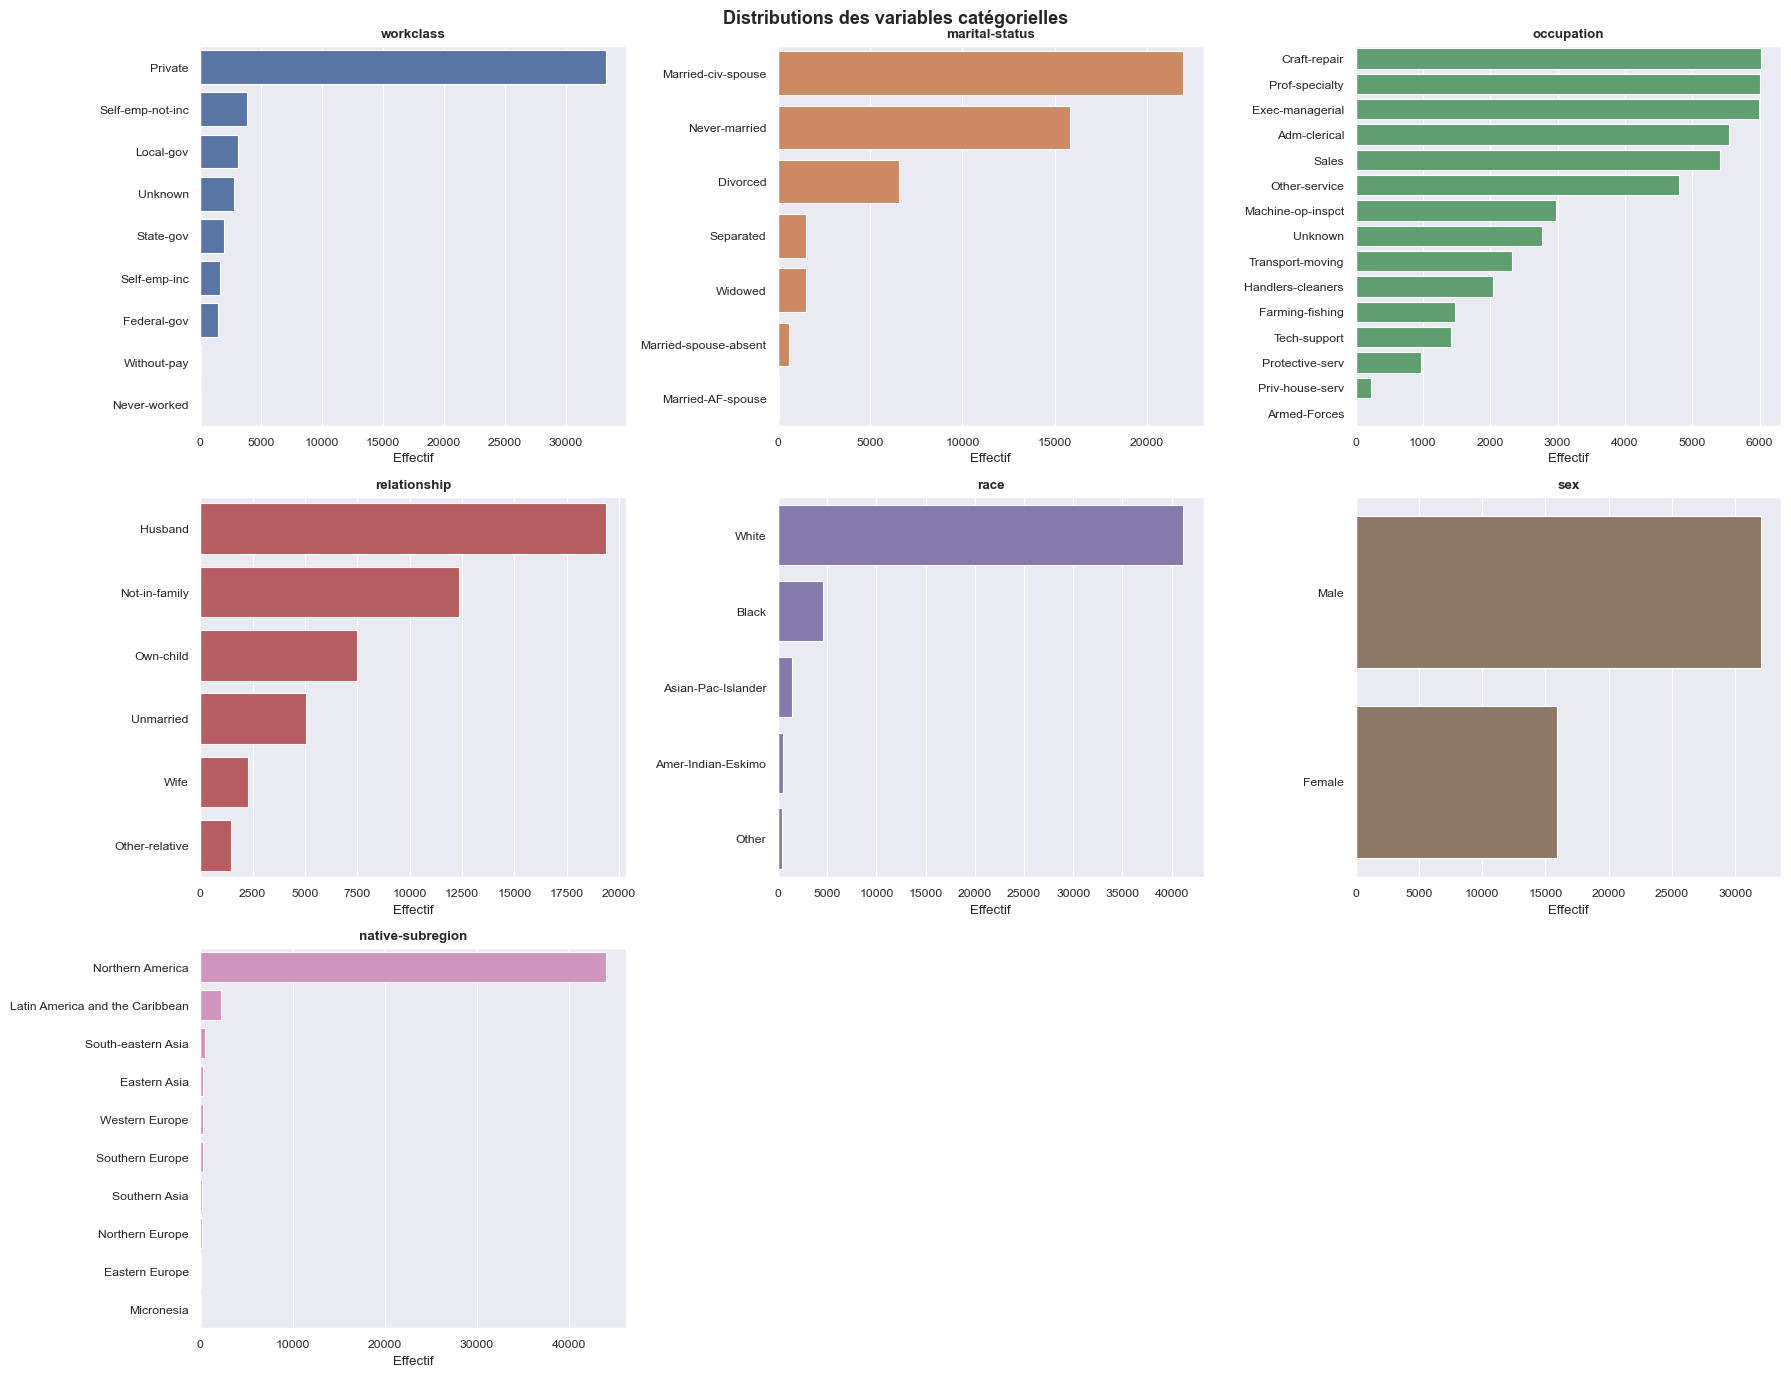

In [69]:
n_cat = len(cat_features)
fig, axs = plt.subplots(3, 3, figsize=(18, 14))
axs = axs.flatten()

for i, col in enumerate(cat_features):
    order = df[col].value_counts().index
    sns.countplot(y=col, data=df, order=order, ax=axs[i],
                  color=sns.color_palette()[i])
    axs[i].set_title(col, fontweight='bold')
    axs[i].set_xlabel('Effectif')
    axs[i].set_ylabel('')

for j in range(n_cat, len(axs)):
    axs[j].set_visible(False)

plt.suptitle('Distributions des variables catégorielles', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / '3-3_distrib_cat.png', bbox_inches='tight')
plt.show()


1. Déséquilibres démographiques (`race` et `sex`) : la catégorie `White` écrase littéralement toutes les autres, représentant la quasi-totalité du dataset. On observe également une nette prédominance des hommes (environ deux fois plus nombreux que les femmes).

2. Emploi et secteur (`workclass` et `occupation`) : le secteur "Private" est ultra-dominant et les catégories liées au gouvernement ou à l'auto-entreprenariat sont marginales. La variable `occupation` est la plus équilibrée. Le trio de tête est composé des métiers techniques (Craft-repair), des spécialistes (Prof-specialty) et des cadres (Exec-managerial).

3. Situation familiale (`marital-status` et `relationship`) : les `Married-civ-spouse` forment le groupe le plus important, suivis des célibataires (`Never-married`). En toute logique, la catégorie `Husband` est la plus représentée.

4. Origine géographique (`native-subregion`) : comme attendu, on frôle le monopole pour `Northern America`. Les autres régions du monde (Europe, Asie, etc.) sont quasiment invisibles à cette échelle.


On retrouve des distributions de données typiques des US. Notre modèle sera donc naturellement mieux entraîné sur des profils d'hommes blancs américain vivant dans les années 90, ce qui est normal, ce dataset étant issu des données de recensement des USA de 1994. Il sera peu probable d'obtenir des résultats fiables pour d'autres ethnies vivants dans d'autres pays et à d'autres époques, voir même pour un homme blanc américain vivant à notre époque.

Il conviendra de surveiller si des catégories très peu représentées (comme "Armed-Forces" ou certaines régions géographiques) qui risquent d'apporter plus de bruit que d'information utile.

### 3.4 Analyse bivariée - Variables numériques vs `income`

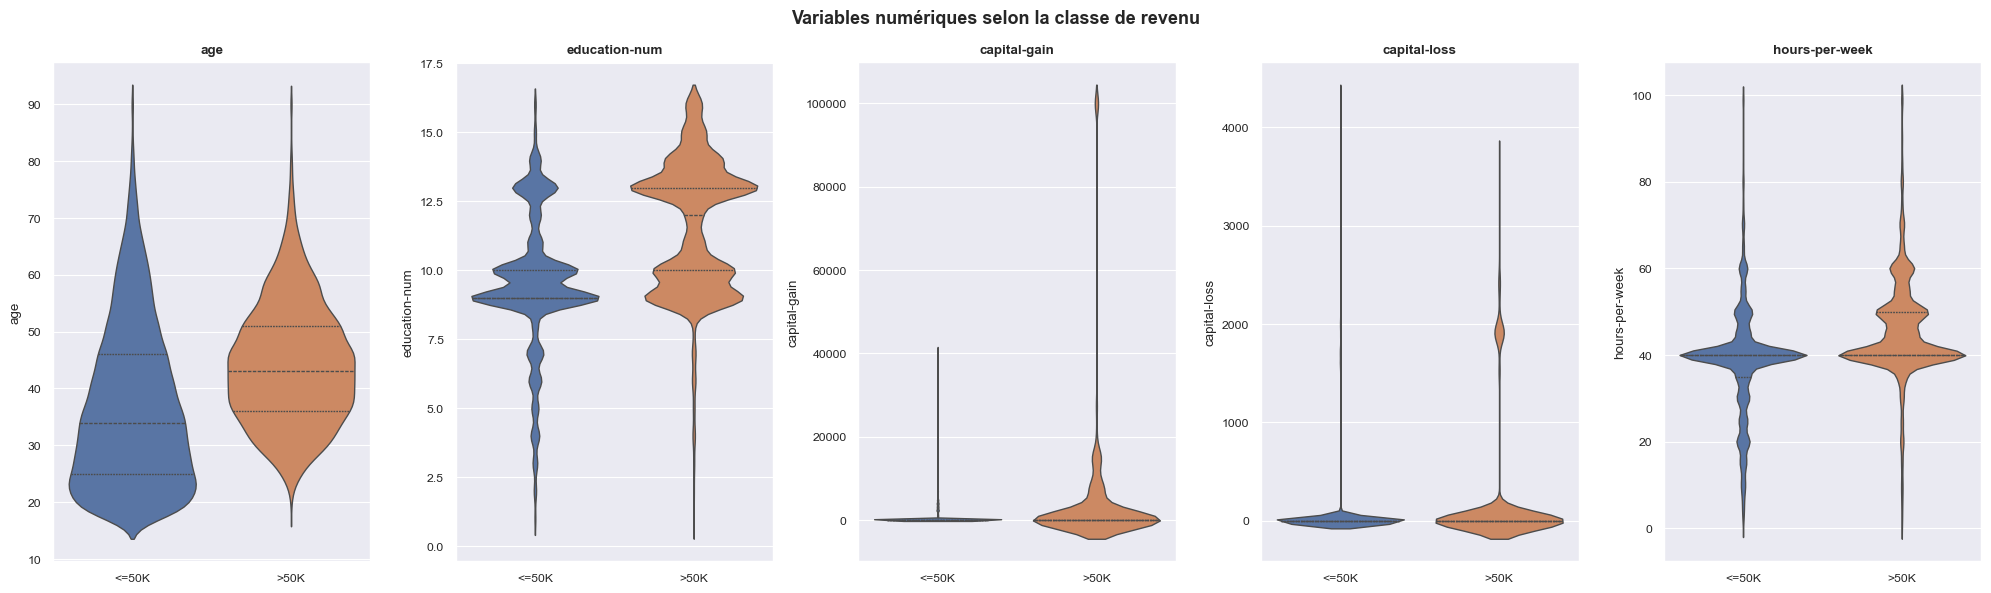

In [70]:
# Violin plots - distribution par classe
fig, axs = plt.subplots(1, 5, figsize=(20, 6))

for i, col in enumerate(num_features):
    sns.violinplot(
        x=target[0], 
        y=col, 
        data=df.replace(decode_target), 
        ax=axs[i], 
        hue=target[0], 
        inner='quartile'
        )
    axs[i].set_title(col, fontweight='bold')
    axs[i].set_xlabel('')

plt.suptitle('Variables numériques selon la classe de revenu', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / '3-4_violin_num_vs_income.png', bbox_inches='tight')
plt.show()


1. Âge vs revenu : La distribution pour les $\le50K$ est très ventrée chez les jeunes (pic autour de 25 ans), tandis que celle des $>50K$ est bien plus haute et centrée sur la quarantaine/cinquantaine. Comme on pouvait s'en douter, un revenu élevé semble être corrélé à l'expérience. On voit clairement que la probabilité de gagner plus de 50K augmente significativement après 30-35 ans.

2. Éducation vs revenu : Pour le groupe $\le50K$, la densité est maximale autour de 9 et 10 (High School). Pour le groupe $>50K$, le ventre du violon se déplace nettement vers le haut, avec des pics marqués à 13 (Bachelor) et au-delà. avec le niveau d'éducation et l'expérience, nous avons deux prédicteurs puissants. Un niveau d'éducation élevé est un sésame très clair pour basculer dans la catégorie supérieure de revenus.

3. Heures par semaine vs revenu : Si les deux groupes ont un pic massif à 40h, le violon orange ($>50K$) est nettement plus large au-dessus de la barre des 40h que le violon bleu. Il y a une corrélation visible entre "travailler plus" et "gagner plus" dans le jeu de donnée considéré, même si la norme des 40h reste dominante pour tout le monde.

4. Capital-gain & capital-loss : Les violons sont très fins à la base (car beaucoup de 0), mais on remarque que les "queues" hautes (les individus avec des gains/pertes importants) appartiennent quasi exclusivement au groupe $>50K$. Posséder des actifs financiers qui génèrent des gains est un marqueur très fort de la classe de revenu supérieure.


Toutes ces variables numériques semblent avoir un pouvoir prédictif. L'âge, l'éducation et les heures travaillées montrent des différences de distribution nettes. Uun modèle de classification devrait pouvoir les utiliser efficacement pour séparer les deux classes de revenus.

On, calcule le coefficient de Spearman entre les variables numériques et la variable cible pour voir les corrélations :

In [71]:
results = {col: spearmanr(df[col], df[target[0]]) for col in num_features}

rho = pd.Series({col: res.statistic for col, res in results.items()},
                name='ρ de Spearman').sort_values(ascending=False)

pval = pd.Series({col: res.pvalue for col, res in results.items()},
                 name='p-value')

spearman = pd.concat([rho, pval], axis=1)

display(spearman.style.background_gradient(subset=['ρ de Spearman'], cmap='YlOrRd'))

,ρ de Spearman,p-value
education-num,0.327736,0.000000
capital-gain,0.276808,0.000000
age,0.269023,0.000000
hours-per-week,0.268557,0.000000
capital-loss,0.137781,0.000000


La variable ayant la plus forte corrélation avec le revenu est le niveau d'éducation. Celle qui en a le moins est la perte de capital.

### 3.5 Analyse bivariée - Variables catégorielles vs `income`

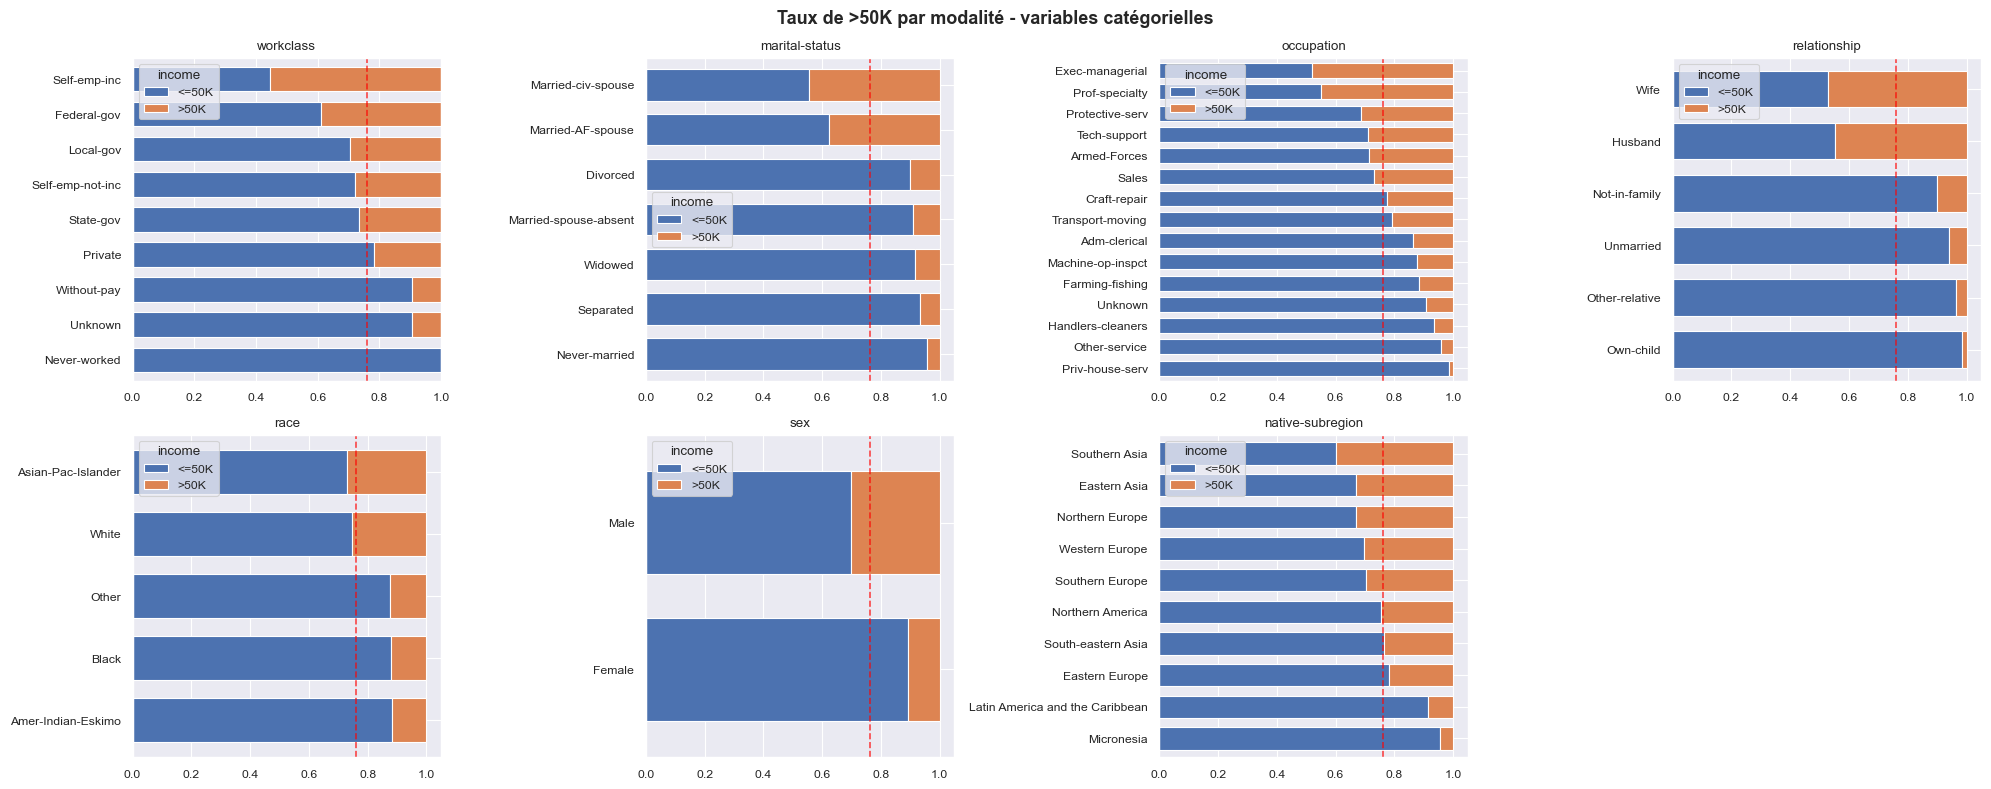

In [72]:
# Stacked bar - taux de >50K par modalité
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for i, col in enumerate(cat_features):

    ct = pd.crosstab(
        df[col], 
        df.replace(decode_target)['income'], 
        normalize='index'
        ).sort_values('>50K', ascending=True)
    
    ct.plot(kind='barh', stacked=True, ax=axs[i], width=0.7)

    # ligne de référence globale
    axs[i].axvline(
        (df[target[0]] == 0).mean(), 
        color='red',
        linestyle='--', 
        alpha=0.7
        ) 
    
    axs[i].set_title(col)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

for j in range(len(cat_features), len(axs)):
    axs[j].set_visible(False)

plt.suptitle('Taux de >50K par modalité - variables catégorielles', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / '3-5_stacked_cat_vs_income.png', bbox_inches='tight')
plt.show()

1. Les boosters de revenu :
    - `workclass` : Les `Self-emp-inc`, entrepreneurs dont l'entreprise est incorporée (personnalité morale distincte de son dirigeant, éq. SARL, SAS, SASU) sont ceux qui s'en sortent le mieux financièrement, suivit par les agents gouvernementaux.
    - `occupation` : Les postes de direction (Exec-managerial) et les spécialistes (Prof-specialty) dominent largement, avec près de 50 % de chances d'être dans la tranche supérieure.
    - `marital-status` : Les personnes `Married-civ-spouse` ont une probabilité plus élevée de gagner >50K (plus de 40 %) par rapport aux célibataires.


2. Les disparités démographiques :
    - `sex` : La proportion d'hommes gagnant >50K est nettement supérieure à celle des femmes.
    - `race` : Les catégories `Asian-Pac-Islander` et `White` affichent des taux de revenus élevés supérieurs aux autres groupes ethniques.

3. Les bas revenus :
    - `relationship` : Les catégories `Own-child` et `Other-relative` ont des taux de revenus élevés quasi nuls. Cela s'explique souvent par l'âge (étudiants) ou le statut de dépendance.
    - `native-subregion` : On voit que certaines régions comme la Micronésie ou l'Amérique Latine sont très peu représentées dans la classe >50K dans cet échantillon.

On va maintenant utiliser le test du Chi² ($\chi^2$) pour vérifier s'il existe une dépendance statistique entre les variables et le revenu, ainsi que le V de Cramér pour mesurer la force de cette association.

Le V de Cramér se lit sur une échelle de 0 à 1 :

 $$V = \sqrt{\frac{\chi^2 / n}{\min(k-1, r-1)}}$$
 (Où $n$ est le nombre d'observations, $k$ le nombre de colonnes et $r$ le nombre de lignes).

In [73]:
def cramers_v(x, y):
    """V de Cramér : force d'association entre deux variables catégorielles."""
    ct = pd.crosstab(x, y)
    chi2_stat, p, dof, _ = chi2_contingency(ct)
    n = ct.sum().sum()
    v = np.sqrt(chi2_stat / (n * (min(ct.shape) - 1)))
    return chi2_stat, p, v

results = []
for col in cat_features:
    chi2_stat, p, v = cramers_v(df[col], df[target[0]])
    results.append({
        'feature':     col,
        'chi²':        round(chi2_stat, 1),
        'p-value':     p,
        'V de Cramér': round(v, 4),
    })

df_chi2 = pd.DataFrame(results).sort_values('V de Cramér', ascending=False).reset_index(drop=True)
display(
    df_chi2.style \
           .background_gradient(subset=['V de Cramér'], cmap='YlOrRd') \
           .format({'p-value': '{:.2e}', 'chi²': '{:,.1f}'})
)


,feature,chi²,p-value,V de Cramér
0,relationship,"9,915.0",0.00e+00,0.454600
1,marital-status,"9,650.5",0.00e+00,0.448500
2,occupation,"5,890.8",0.00e+00,0.350400
3,sex,"2,210.2",0.00e+00,0.214600
4,workclass,"1,578.0",0.00e+00,0.181300
5,race,475.4,1.39e-101,0.099500
6,native-subregion,360.9,2.91e-72,0.086700


1. Influence forte : `relationship` (V = 0.4546), `marital-status` (V = 0.4485) sont les deux prédicteurs les plus puissants. Un score proche de 0,5 est considéré comme une association très forte. `occupation` (V = 0,3504) vient juste après avec une influence "moyenne à forte". Ce qui est cohérent avec le graphique précédent.
2. Influence modérée : `sex` (V = 0,2146) et `workclass` (V = 0,1813) ont une influence réelle mais plus modérée. Cela confirme que si le sexe est un facteur, il l'est moins que le type de métier ou la situation familiale dans ce jeu de données.
3. Inluences faibles : `race` (V = 0,0995) et `native-subregion` (V = 0,0867) ont les scores les plus bas. Bien que statistiquement significatives (p-value quasi nulle), leur pouvoir de prédiction est beaucoup plus faible que les autres. Étant donné le faible score de `native-subregion` et le fait qu'elle soit ultra-dominée par une seule modalité, on pourrais envisager de la supprimer.

### 3.6 Corrélations

Nous allons calculer les corrélations entre les variables numériques à l'aide du coefficient de Spearman. En effet, nos données ne suivent pas une loi normale :

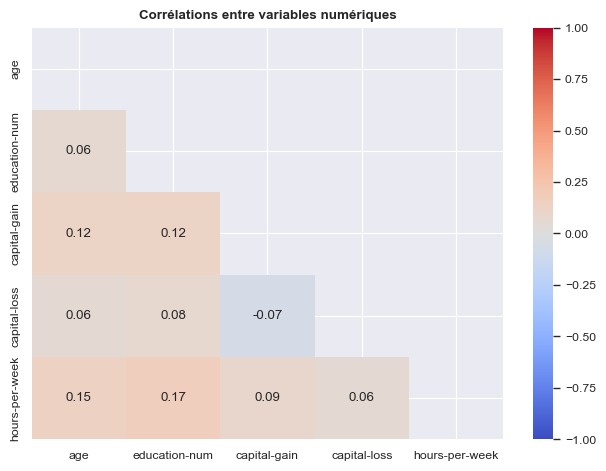

In [74]:
# Matrice de corrélation entre features numériques
corr = df[num_features].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0,
    mask=mask,
    vmin=-1, vmax=1
)
plt.title('Corrélations entre variables numériques', fontweight='bold')


plt.tight_layout()
plt.savefig(FIG_DIR / '3-6_correlations_spearman.png', bbox_inches='tight')
plt.show()

Les variables numériques présentent une grande indépendance ($r < 0.20$), garantissant l'absence de redondance d'information. Les liens les plus visibles, bien que faibles, concernent le temps de travail hebdomadaire associé au niveau d'éducation et à l'âge.

Pour les variables catégorielles deux à deux, nous allons, comme précédement le V de Cramér.

In [75]:
results = {}
for col1 in cat_features:
    results[col1] = {}
    for col2 in cat_features:
        _, _, v = cramers_v(df[col1], df[col2])
        results[col1][col2] = round(v, 4)

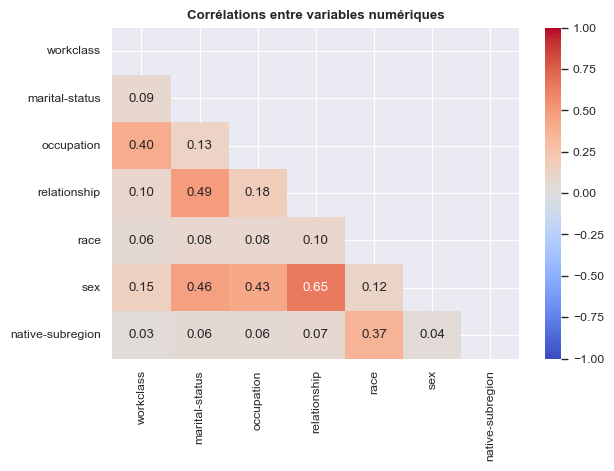

In [76]:
corr_cramer = pd.DataFrame(results)
mask = np.triu(np.ones_like(corr_cramer, dtype=bool))

sns.heatmap(
    corr_cramer, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0,
    mask=mask,
    vmin=-1, vmax=1
)
plt.title('Corrélations entre variables numériques', fontweight='bold')


plt.tight_layout()
plt.savefig(FIG_DIR / '3-6_correlations_cramer.png', bbox_inches='tight')
plt.show()

Contrairement aux variables numériques qui étaient indépendantes, on observe ici des liens forts, voire de la redondance, entre certaines variables catégorielles.

1. Corrélations les plus élevées : `relationship`, `sex` et `marital-status`
    - `relationship` et `sex` (0,65) : corrélation la plus forte. Elle est logique car certaines modalités de relationship comme "Husband" ou "Wife" définissent quasi systématiquement le sexe de l'individu.

    - `relationship` et `marital-status` (0,49) : lien très marqué. Si une personne est "Married-civ-spouse", elle sera très probablement enregistrée comme "Husband" ou "Wife".

    - `sex` & `marital-status` (0,46) : corrélation significative qui reflète les structures sociales de l'échantillon.

2. Les liens Professionnels :
    - `occupation` & `sex` (0,43) : corrélation modérée due à la répartition des métiers différente selon le sexe.

    - `sex` & `occupation` (0,40) : Un lien attendu ; le type de métier (`occupation`) est souvent lié au secteur d'activité (`workclass`).

3. Les liens géographiques et ethniques : il existe une corrélation modérée entre `race` & `native-subregion` (0,37). Il n'est pas étonnant que cette corrélation ne soit que modérée ici, contrairement à ce que l'on aurait pu attendre. En effet, la majorité des entrées du dataset correspondant à des personnes nées aux USA, pays présentant une certaine hétérogénéité éthnique.

Nous avons donc ici un risque de multicolinéarité (redondance d'information). `relationship`, `sex` et `marital-status` partagent globalement des informations similaires. Comme ils ont tous les trois un fort impact sur le revenu, les garder tous dans votre modèle risque de sur-pondérer ces facteurs au détriment d'autres variables comme l'éducation ou l'âge.

Afin, pour regarder les corrélation entre variables numériques et catégorielles, nous allons calculer les rapport de corrélation Eta² ($\eta^2$).

In [77]:
def eta_squared(num_col, cat_col):
    groups = [g[num_col].values for _, g in df.groupby(cat_col)]
    H, _ = kruskal(*groups)
    k = len(groups)
    n = df[[num_col, cat_col]].dropna().__len__()
    return (H - k + 1) / (n - k)


corr_eta = pd.DataFrame(index=num_features, columns=cat_features, dtype=float)
for num in num_features:
    for cat in cat_features:
        corr_eta.loc[num, cat] = eta_squared(num, cat)

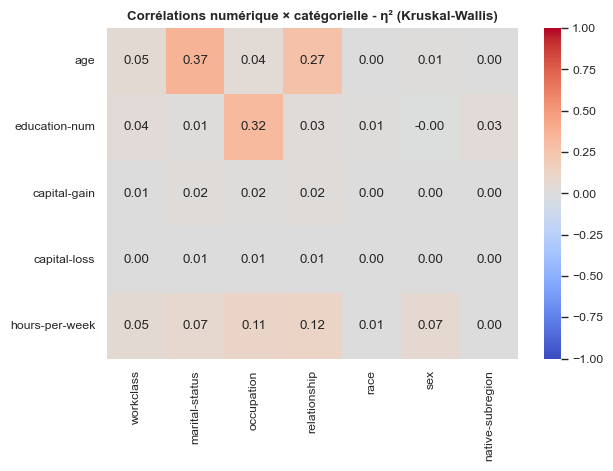

In [78]:
sns.heatmap(
    corr_eta, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0,
    vmin=-1, vmax=1
)
plt.title("Corrélations numérique × catégorielle - η² (Kruskal-Wallis)", fontweight='bold')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(FIG_DIR / '3-6_correlations_eta.png', bbox_inches='tight')
plt.show()

La corrélation la plus forte est entre l'âge (`age`) et la structure familiale (`marital-status` et `relationship`). C'est logique : on ne naît pas "marié" ou "chef de famille". Ces statuts s'acquièrent avec le temps, ce qui crée cette dépendance statistique naturelle.

Une autre corrélation observable entre `education-num` et `occupation`. C'est le reflet de la spécialisation professionnelle. Certains métiers (médecins, cadres, techniciens) exigent des niveaux de diplômes spécifiques, ce qui lie fortement ces deux variables.

### 3.7 Sélection des features

Comme nous avons pu le voir précédement, il existe une certaines redondance entre certaines variables et d'autres n'ont que peu de pouvoir discriminant. Avant de procéder à la sélection, recalculons la MI pour toutes les variables.

In [79]:
# Encoder les catégorielles pour le calcul de MI
df_enc = df.copy()
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_enc[cat_features] = oe.fit_transform(df[cat_features].astype(str))

In [80]:
X_all = df_enc[num_features + cat_features]
y_all = df_enc[target[0]]

discrete_mask = [False] * len(num_features) + [True] * len(cat_features)

mi_scores = mutual_info_classif(
    X_all, y_all, discrete_features=discrete_mask, random_state=SEED
)

mi_series = pd.Series(mi_scores, index=num_features+cat_features) \
              .sort_values(ascending=True)

mi_series

native-subregion    0.004439
race                0.005647
workclass           0.015412
sex                 0.025434
capital-loss        0.035647
hours-per-week      0.040303
occupation          0.063814
education-num       0.066531
age                 0.067297
capital-gain        0.082314
marital-status      0.108944
relationship        0.114753
dtype: float64

In [81]:
# Tableau de synthèse
mi_table = mi_series.sort_values(ascending=False).rename('MI').to_frame()
mi_table['type'] = ['numérique' if c in num_features else 'catégorielle' for c in mi_table.index]

# On ajoute le V de Cramér et le ρ de Spearman :
mi_table = pd.concat([mi_table, df_chi2.set_index('feature')['V de Cramér'], spearman['ρ de Spearman']], axis=1)

display(mi_table.style.background_gradient(subset=['MI'], cmap='YlOrRd'))

,MI,type,V de Cramér,ρ de Spearman
relationship,0.114753,catégorielle,0.454600,nan
marital-status,0.108944,catégorielle,0.448500,nan
capital-gain,0.082314,numérique,nan,0.276808
age,0.067297,numérique,nan,0.269023
education-num,0.066531,numérique,nan,0.327736
occupation,0.063814,catégorielle,0.350400,nan
hours-per-week,0.040303,numérique,nan,0.268557
capital-loss,0.035647,numérique,nan,0.137781
sex,0.025434,catégorielle,0.214600,nan
workclass,0.015412,catégorielle,0.181300,nan


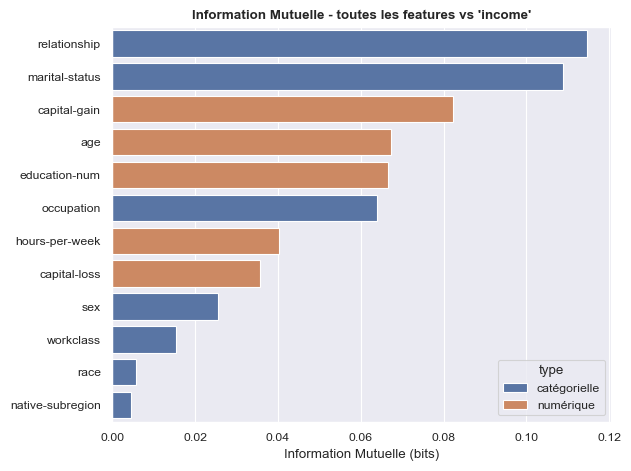

In [82]:
# Barplot horizontal
sns.barplot(data=mi_table, x='MI', y=mi_table.index, hue='type')
plt.title(f"Information Mutuelle - toutes les features vs '{target[0]}'", fontweight='bold')

plt.xlabel("Information Mutuelle (bits)")
plt.ylabel('')

plt.tight_layout()
plt.savefig(FIG_DIR / '3-7_mutual_info.png', bbox_inches='tight')
plt.show()

Nous allons donc supprimer `native-subregion` et `race` qui n'apportent que peu d'informations (MI trop faible), ainsi que `relationship`, afin de casser la redondance avec `marital-status` et `sex` (même si elle possède un MI élevé, elle est redondante).

In [83]:
for col in ['native-subregion', 'race', 'relationship']:
    remove_col(col)

Colonne 'native-subregion' supprimée.
Colonne 'race' supprimée.
Colonne 'relationship' supprimée.


In [84]:
df.head()

,age,workclass,education-num,marital-status,occupation,sex,capital-gain,capital-loss,hours-per-week,income
0,39,State-gov,13,Never-married,Adm-clerical,Male,2174,0,40,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Male,0,0,13,0
2,38,Private,9,Divorced,Handlers-cleaners,Male,0,0,40,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Male,0,0,40,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Female,0,0,40,0
